# Comparing the routing performances of the road graphs 

In [20]:
import networkx as nx
import osmnx as ox

import matplotlib.pyplot as plt

import re
import pandas as pd
import geopandas as gpd
import time

pd.set_option('display.max_columns', None)

In [21]:
G_BTS = nx.read_gpickle('data/BTS_florida_G_non_simplified.plk')

G_OSM = nx.read_gpickle('data/OSM_florida_G_non_simplified.plk')

In [24]:
def get_edge_attribute(G, node=0):
    i,j = list(G.edges())[node]
    return G.edges[i,j,0]

In [25]:
get_edge_attribute(G_OSM,1)

{'maxspeed': 40.0,
 'id': 4385935,
 'length': 210.589,
 'geometry': <shapely.geometry.linestring.LineString at 0x1a363914e0>,
 'duration': 0.003271348450051698}

In [26]:
get_edge_attribute(G_BTS,1)

{'maxspeed': 70,
 'duration': 0.023221529127040938,
 'length': 2616.0,
 'geometry': <shapely.geometry.linestring.LineString at 0x1a1a3fa278>}

The networks are directed. As for highways all paths are bidirectionnal we will simply make the graph undirected.

In [27]:
G_bts_u = G_BTS.to_undirected()
G_osm_u = G_OSM.to_undirected()

# Test 1 
This will test a single edge path to compare the performances of the generated graphs


In [28]:
hwy_dest = (25.760534, -80.489752)
hwy_ori = (25.912947, -81.368603) 

For theses origin and destination points google maps predicts:
* Distance 91 km (57 miles)
* Duration 1 h

In [51]:
def path_length(G, path_nodes, weigth = 'length'):
    dist = [G.edges[path_nodes[i],path_nodes[i+1],0][weigth] for i in range(len(path_nodes)-1)]
    return sum(dist)

def process_graph(G,orig,dest,weight='duration',orig_dest_size=100,algo='astar',show_time=True):
    start = time.time()
    node_orig,dist_orig = ox.distance.get_nearest_node(G, orig, method='haversine', return_dist=True)
    node_dest,dist_dest = ox.distance.get_nearest_node(G, dest, method='haversine', return_dist=True)
    
    if algo == 'astar':
        shortest_path_nx = nx.astar_path(G, node_orig, node_dest, weight=weight)
        
    elif algo == 'dijkstra':
        shortest_path_nx = nx.dijkstra_path(G, node_orig, node_dest, weight=weight)
        
    else:
        raise AssertionError(f'The parameter "algo" can either be "astar" or "dijkstra", not {algo}')
    
    distance_highway = path_length(G,shortest_path_nx)
    
    total_dist =  dist_orig + distance_highway + dist_dest
    
    if show_time:
        print(f'Graph processing time: {time.time()-start} s')
    
    return shortest_path_nx, dist_path, total_dist, node_orig, node_dest
    

def get_route(G,orig,dest,weight='duration',orig_dest_size=100,algo='astar',show_time=True):
    
    shortest_path_nx, dist_path, total_dist, node_orig, node_dest = process_graph(G,orig,dest,weight='duration',orig_dest_size=100,algo='astar',show_time=True)
    
    fig, ax = plt.subplots(figsize=(15, 7))
   
    ax.scatter(orig[1],orig[0],marker='x',s=orig_dest_size,zorder=5)
    ax.scatter(dest[1],dest[0],marker='x',s=orig_dest_size,zorder=10)
    ox.plot_graph(G, edge_color="#bfbfbf", node_color="#595959",bgcolor="w",ax=ax, show=False)
    ox.plot.plot_graph_route(G, shortest_path_nx, route_color='g', route_linewidth=4, route_alpha=0.9, orig_dest_size=100,ax=ax)
    
    if weight=='length':
        
        print(f'Distance {dist_path/1000} [km]')
        
    if weight=='duration':
        if dist_path>1:
            print(f'Duration {dist_path} [h] \nDistance {total_dist/1000} [km]')
            
        else:
            print(f'Duration {dist_path*60} [min] \nDistance {total_dist/1000} [km]')
    
    else:
        print(f'{str(weight)}: {dist_path/1000}')
        
    return node_orig, node_dest
              

## TODO: Improve this function to have a more flexible target opti function

Graph processing time: 0.324552059173584 s
dist_path: 5.086615593505357 | distance_highway:5.086615593505357


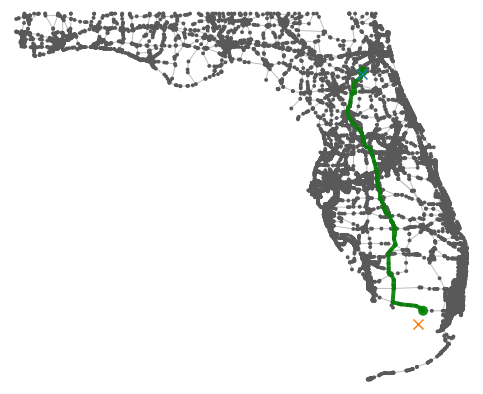

Duration 5.086615593505357 [h] 
Distance 606.598011029287 [km]


(13662, 6128)

In [52]:
get_route(G_bts_u,hwy_ori,hwy_dest,weight='duration')

The BTS graph shows good results comparing to google maps. It can be observed though that the estimated duration is 

Graph processing time: 0.7881391048431396 s
dist_path: 7.221276437450251 | distance_highway:7.221276437450251


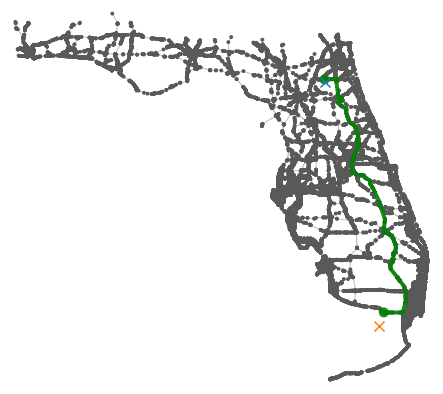

Duration 7.221276437450251 [h] 
Distance 647.0919598906016 [km]


(14079, 28115)

In [53]:
get_route(G_osm_u,hwy_ori,hwy_dest,weight='duration')

Obviously the created OSM graph has some issues. This has been further investigated in the `OSM_problems` notebook.
The mains reason is that some egdes seem not to be correctly mapped (intersections are sinks)

In [32]:
# ox.plot_graph_folium(G_osm_u, popup_attribute= 'maxspeed')

# Test 2
This time a longer path will be tested.

In [54]:
hwy_dest = (25.382380, -80.475159)
hwy_ori =(30.439440, -85.057166)

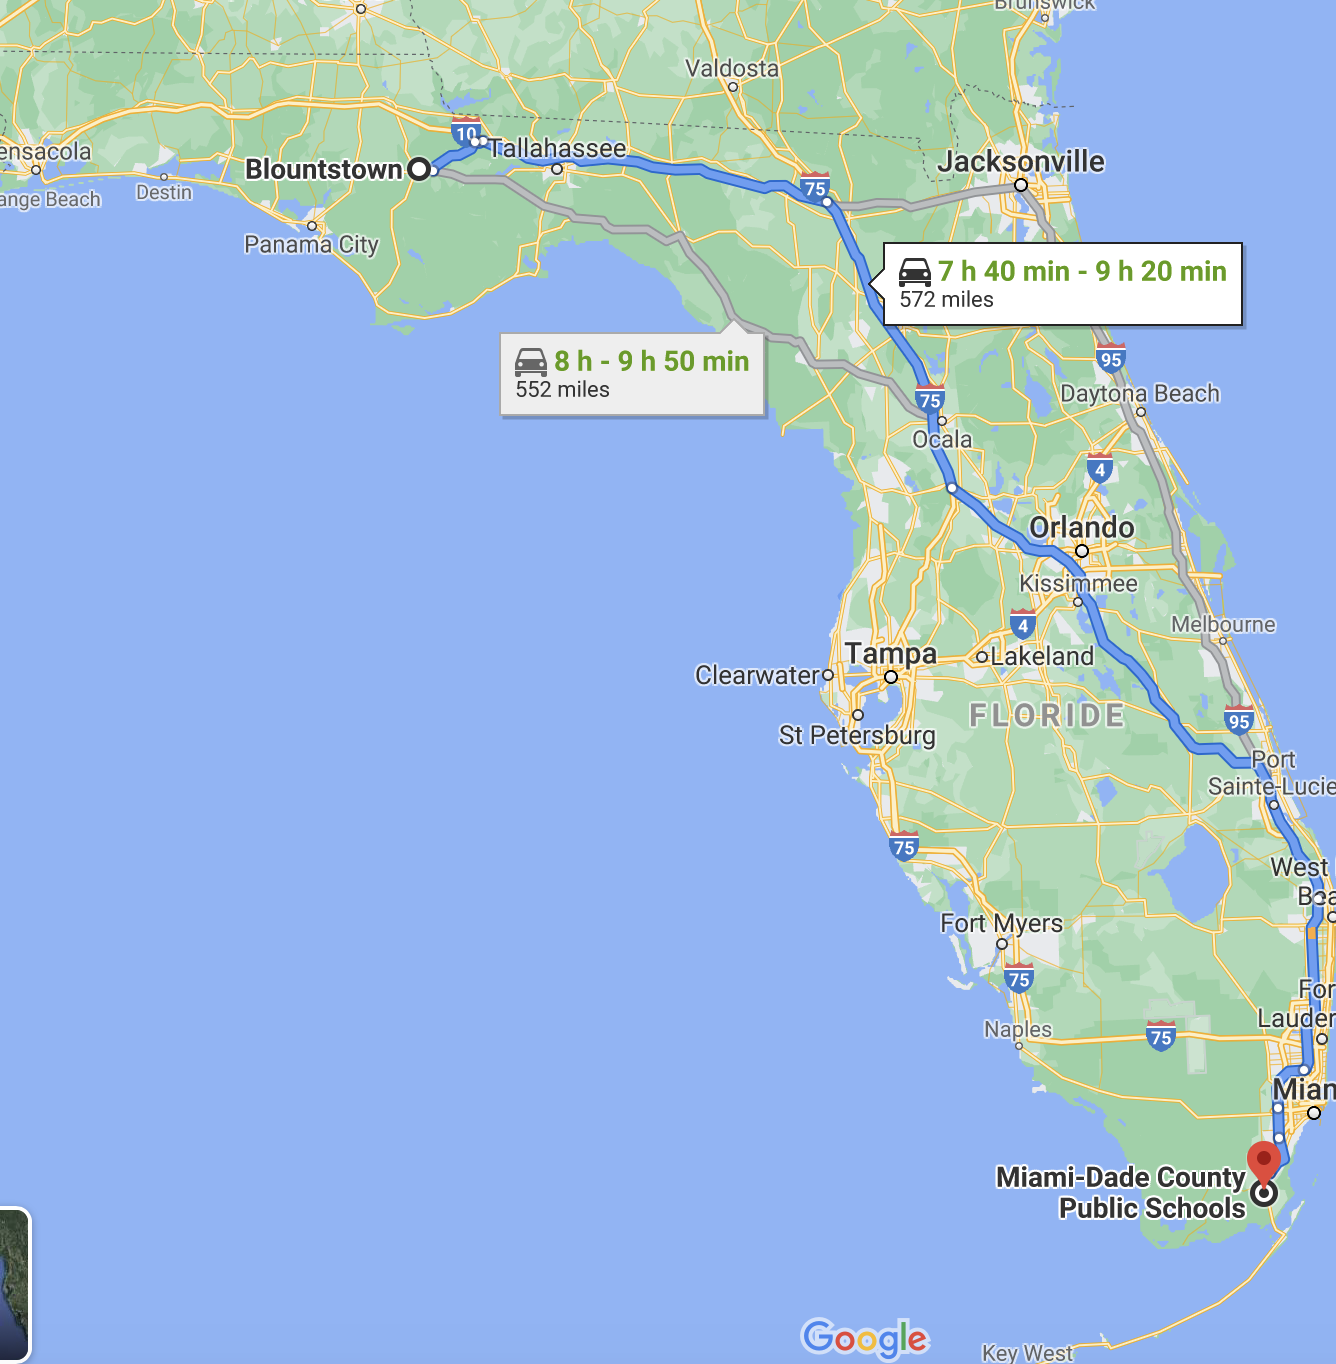

In [55]:
from IPython.display import Image
Image("Img/Test2.png",width=500, height=800)

For this theses origin and arrival google maps predicts:
* Distance 915 km (572 miles)
* Duration 8-9.5 hours

Graph processing time: 0.3144040107727051 s
dist_path: 7.559016060492432 | distance_highway:7.559016060492432


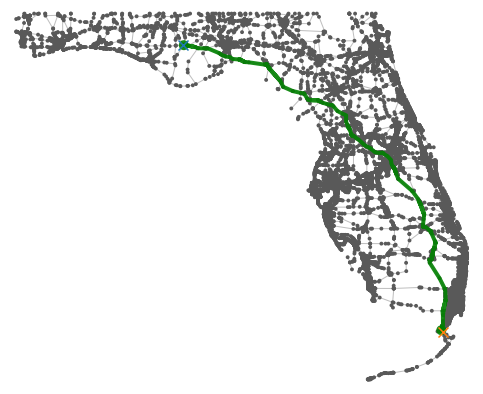

Duration 7.559016060492432 [h] 
Distance 857.8154317300931 [km]


(1567, 6468)

In [56]:
get_route(G_bts_u,hwy_ori,hwy_dest, weight='duration')

Google maps took a different route than our graph beceause they minimize the duration by taking account live data such as road congestion and road constructions/maintenance. Thus the distance is slightly longer for G_maps but the results are still satisfying.

Graph processing time: 0.8109607696533203 s
dist_path: 9.728563732495383 | distance_highway:9.728563732495383


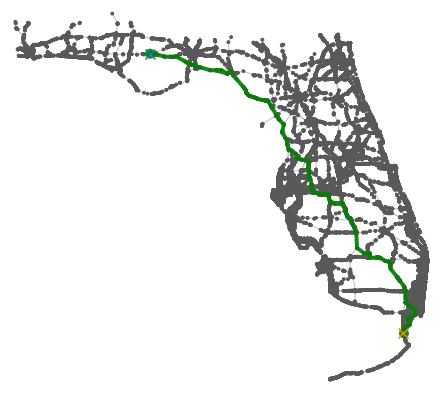

Duration 9.728563732495383 [h] 
Distance 884.4347038336603 [km]


(271, 43913)

In [57]:
get_route(G_osm_u,hwy_ori,hwy_dest)

# Test 3 
See if the simplified graph from the BTS data is a good approximation. 
Note that this would make less sense for the OSM data as for OSM, each graph segment has its own speed attached. A weighted average could be taken but it has been observed that the graph itself seems to have some inperfections (Nodes are not on juntions).

In [58]:
hwy_dest = (25.523937, -80.919225)
hwy_ori =(29.928830, -81.902701)

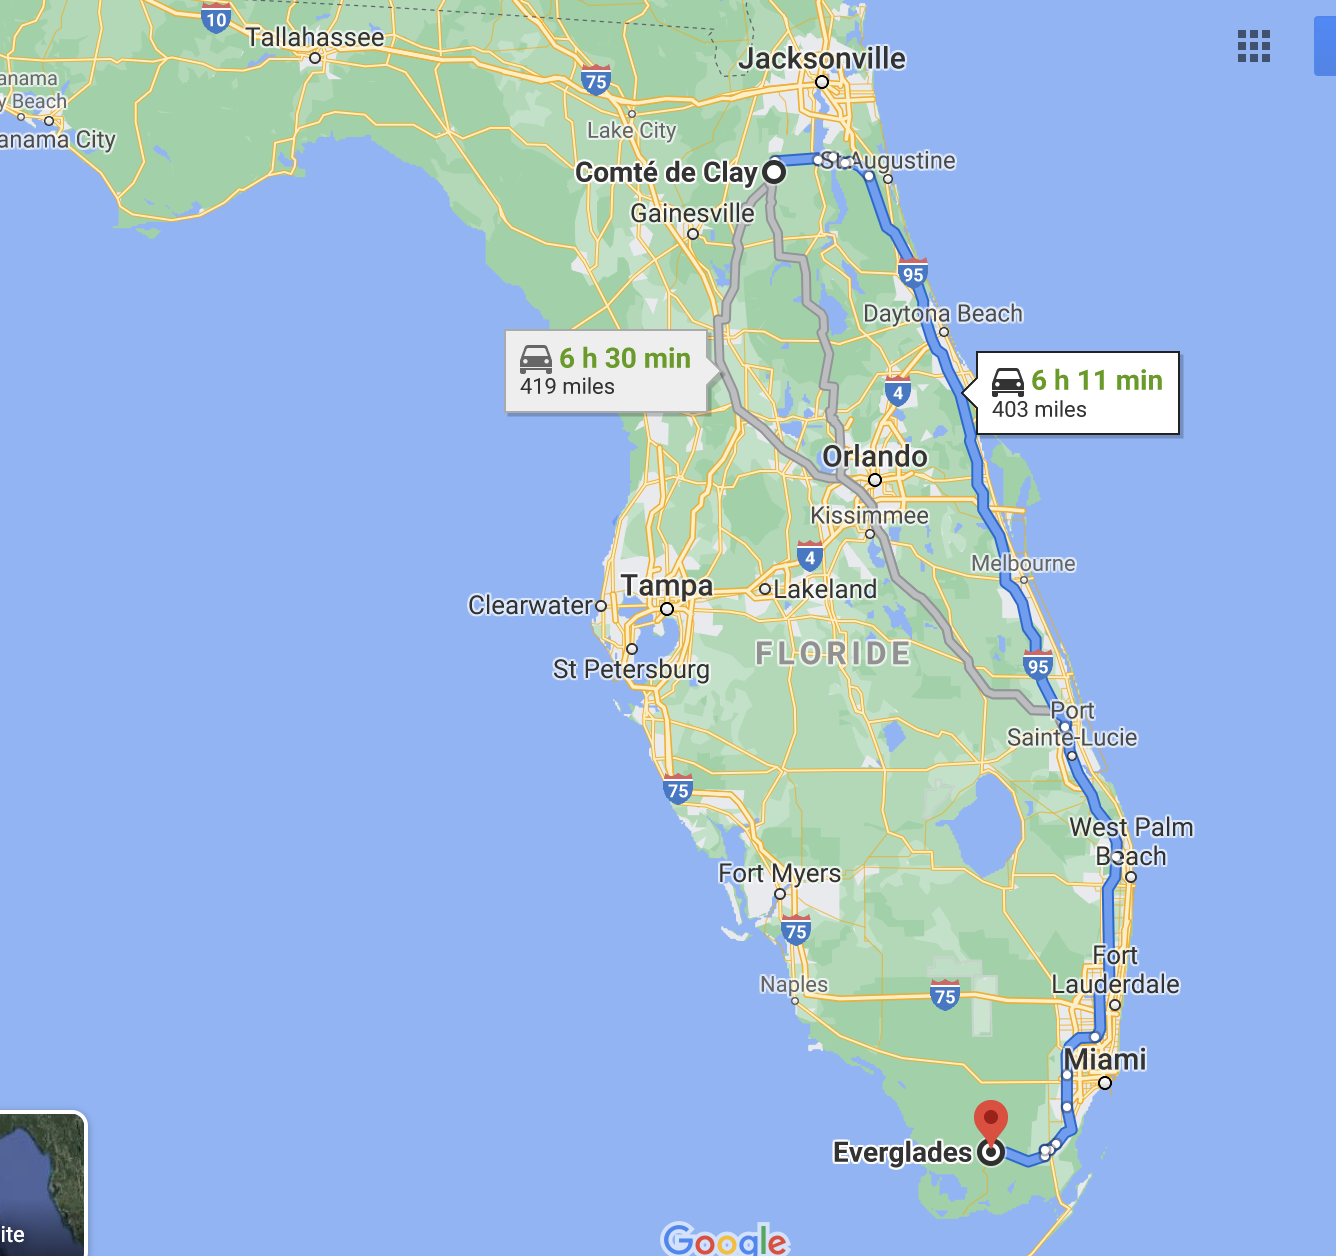

In [62]:
from IPython.display import Image
Image("Img/Test3.png",width=500, height=800)

In [59]:
G_bts_s_u = clean_graph(nx.read_gpickle('data/BTS_florida_G.plk')).to_undirected()

Graph processing time: 0.30627989768981934 s
dist_path: 5.086615593505357 | distance_highway:5.086615593505357


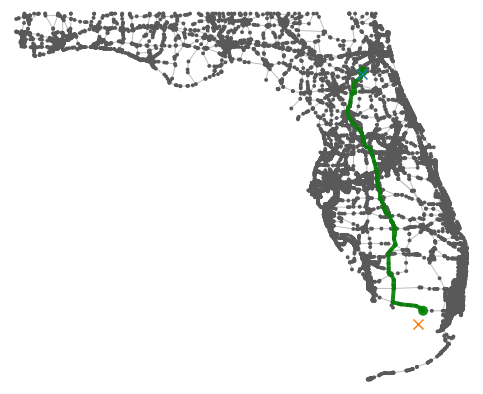

Duration 5.086615593505357 [h] 
Distance 606.598011029287 [km]


(13662, 6128)

In [60]:
get_route(G_bts_u,hwy_ori,hwy_dest, weight='duration')

Graph processing time: 0.0762171745300293 s
dist_path: 5.490196182863509 | distance_highway:5.490196182863509


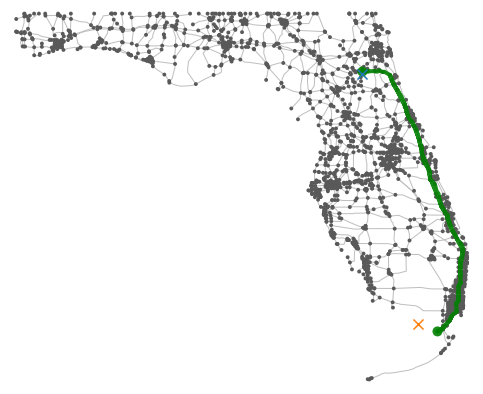

Duration 5.490196182863509 [h] 
Distance 663.1386843054065 [km]


(13662, 6473)

In [61]:
get_route(G_bts_s_u,hwy_ori,hwy_dest, weight='duration')